# Trabalho de Pós-Graduação: Análise de Cluster de Dados de Países

### Github:
- Repositório: https://github.com/Pinho-514/PD_AlgoritmosInteligenciaArtificialClusterizacao

## Parte 1: Infraestrutura - Configuração do Ambiente Virtual e Instalação de Dependências

Antes de executar este notebook, siga as etapas abaixo para configurar o ambiente virtual e instalar as dependências necessárias:

1. **Criar e ativar o ambiente virtual:**
   ```bash
   python -m venv venv

   .\venv\Scripts\activate
   ```

2. **Instalar as dependências:**
   ```bash
   pip install -r requirements.txt
   ```

Certifique-se de que o arquivo `requirements.txt` está na mesma pasta que este notebook e contém todas as bibliotecas necessárias para a execução do código.

In [25]:
# Importar bibliotecas necessárias
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, euclidean_distances

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage

import kagglehub
from ydata_profiling import ProfileReport

# Configurar o ambiente do notebook
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

## Parte 2: Escolha de base de dados

In [5]:
# Baixar o conjunto de dados do Kaggle
path = kagglehub.dataset_download("rohan0301/unsupervised-learning-on-country-data")

# Carregar o conjunto de dados
df = pd.read_csv(path + "/Country-data.csv")

100%|██████████| 5.21k/5.21k [00:00<00:00, 2.14MB/s]

Extracting files...


In [7]:
# Verificar as dimensões do conjunto de dados
num_countries = df.shape[0]
num_features = df.shape[1]

print(f"Número de países no conjunto de dados: {num_countries}")
print(f"Número de features: {num_features}")

Número de países no conjunto de dados: 167
Número de features: 10


In [9]:
# Definir features para clusterização
features = df.columns.drop('country')
X = df[features]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 11.9 KB


In [10]:
profile = ProfileReport(df, title="Country Data Profiling Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 62601.55it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Plotando distribuições para cada feature...


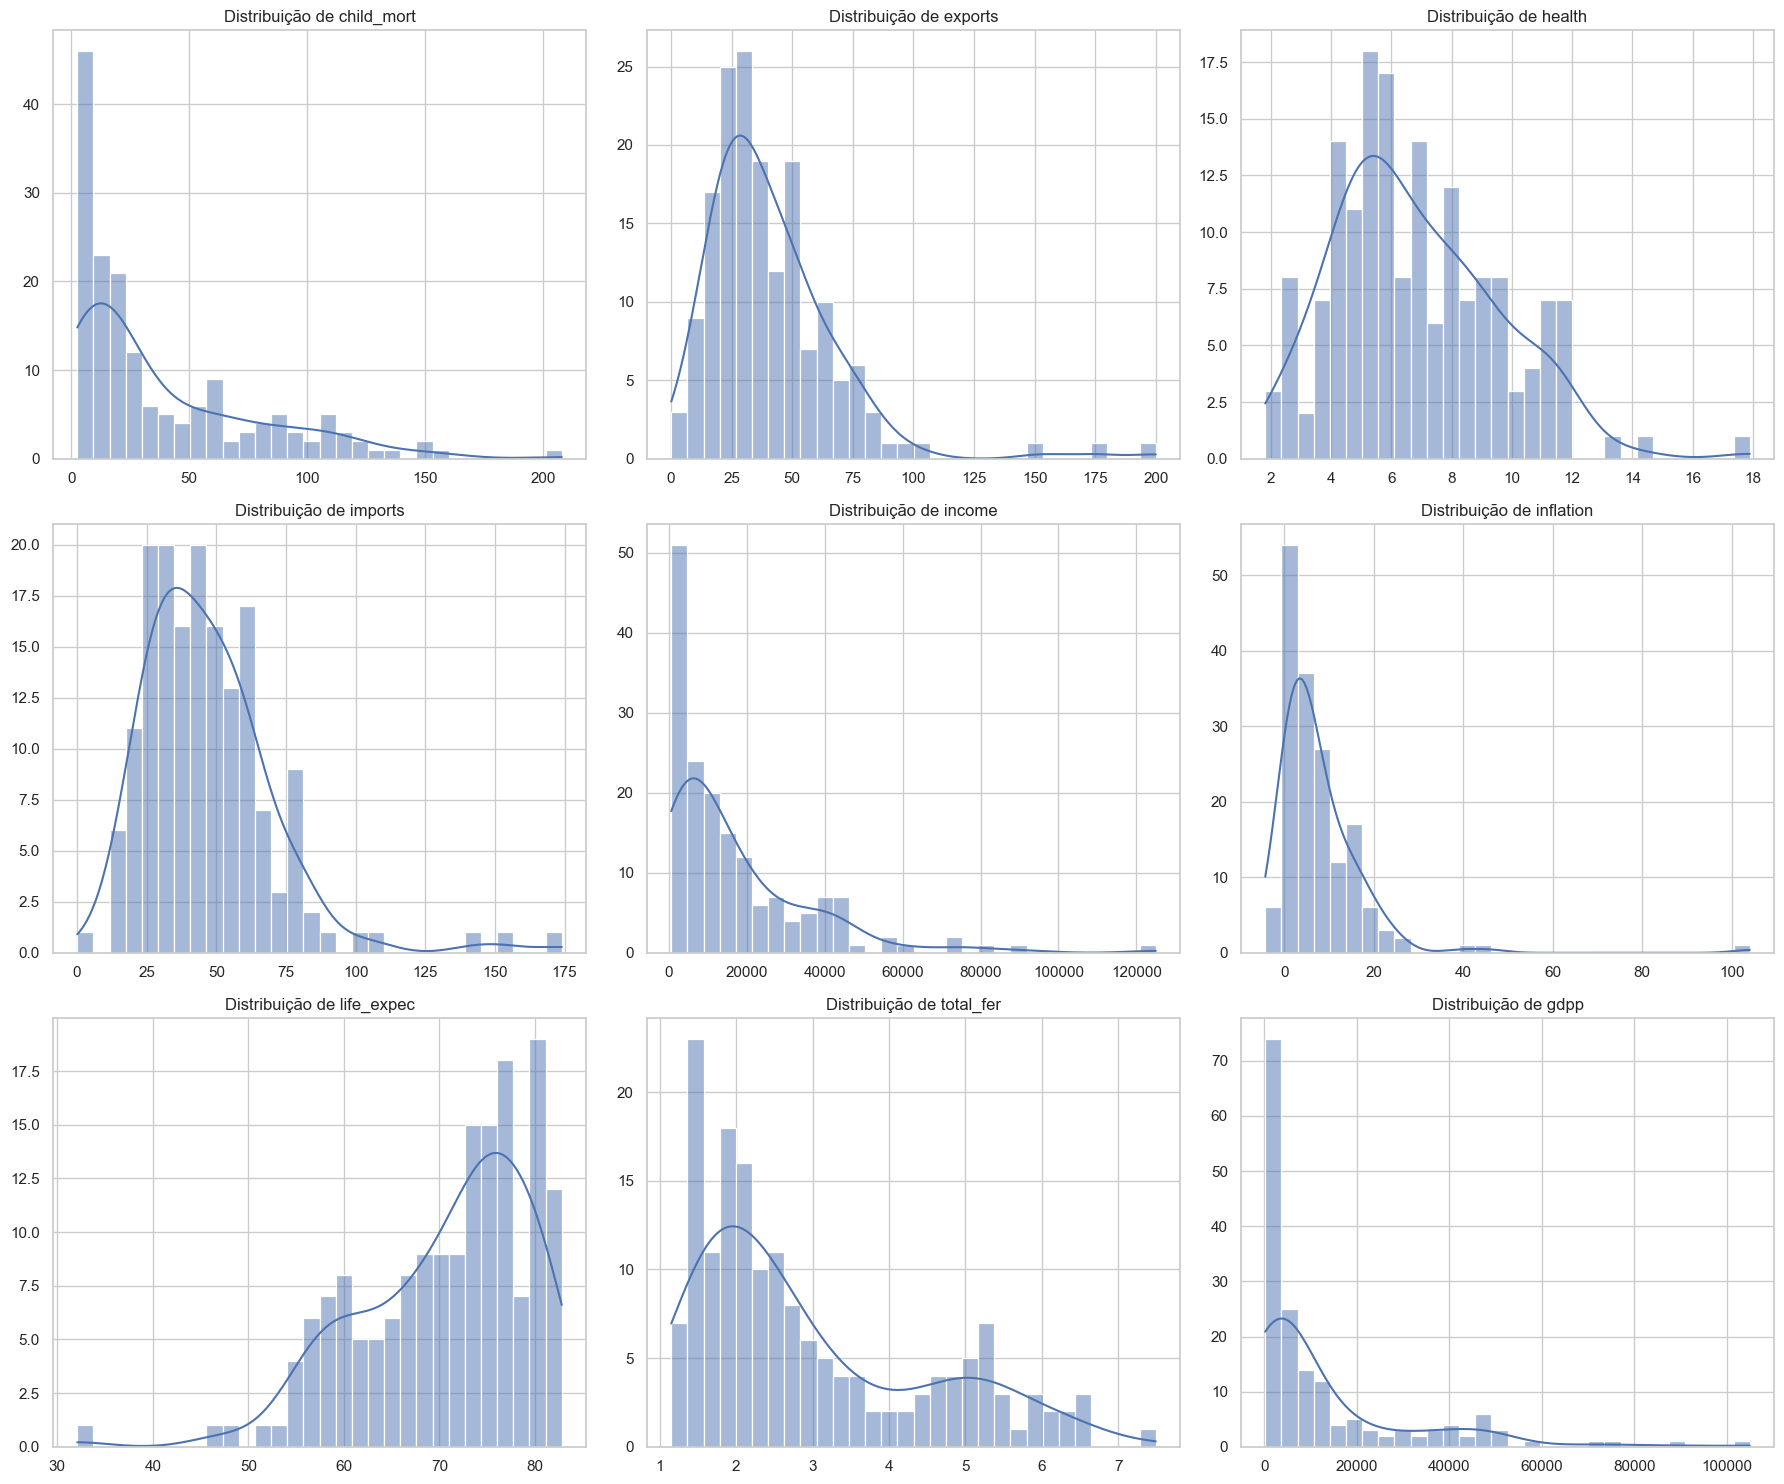

In [12]:
# Plotar a faixa dinâmica (distribuição) de cada feature
print("Plotando distribuições para cada feature...")

plt.figure(figsize=(18, 15))
for i, col in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribuição de {col}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

Plotando boxplots para cada feature...


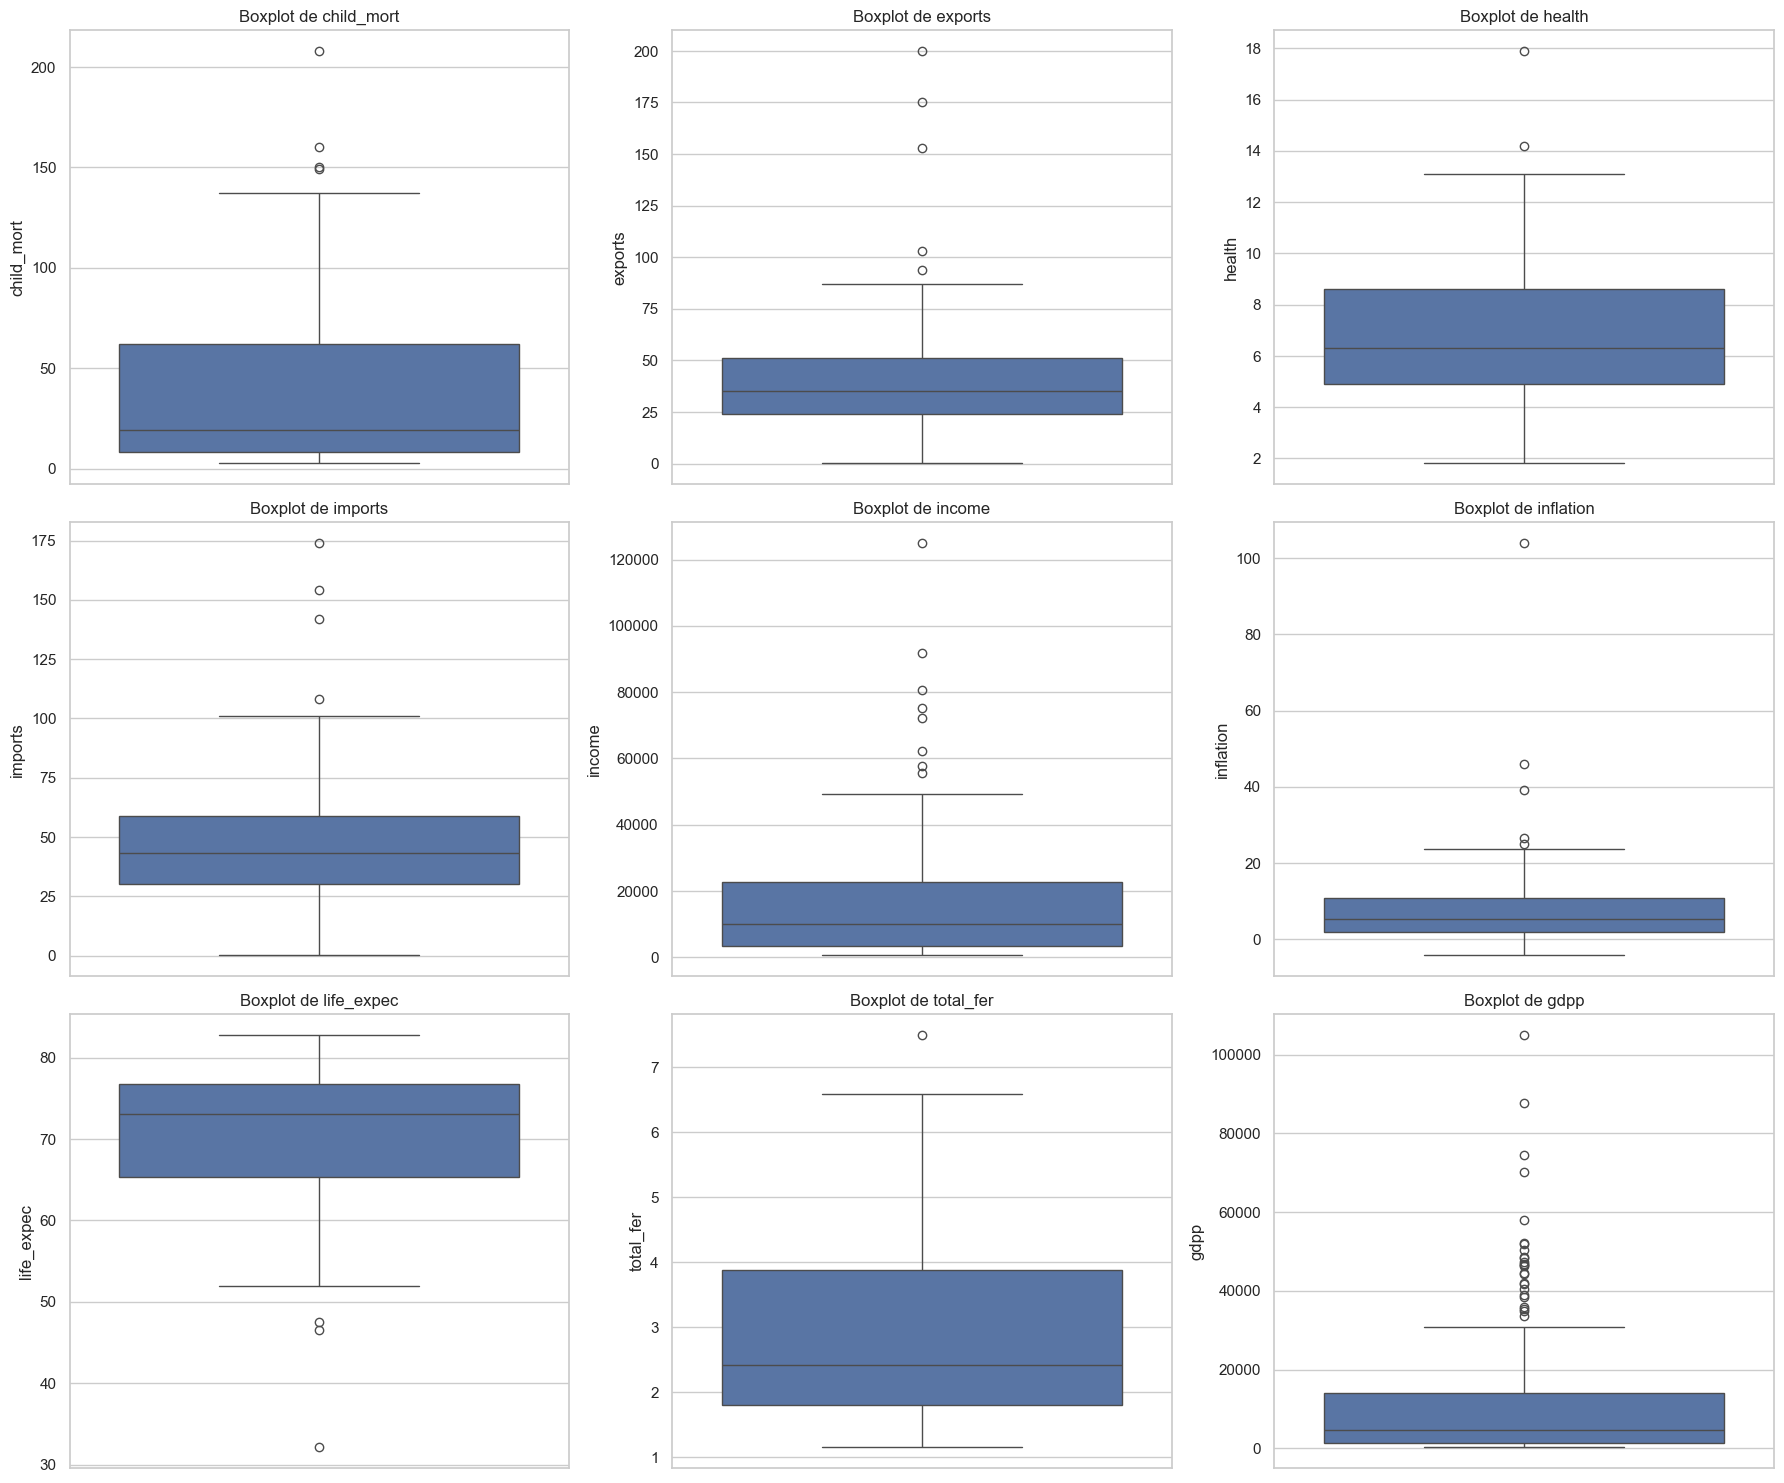

In [13]:
# Use boxplots para uma visão mais clara das escalas e outliers
print("Plotando boxplots para cada feature...")

plt.figure(figsize=(18, 15))
for i, col in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

Análise da Faixa Dinâmica e Pré-processamento para Clusterização

1. Análise dos Resultados (Faixa Dinâmica)

Os gráficos boxplot acima demonstram a distribuição e a faixa dinâmica de cada uma das features da base. 

Vale destacar dois pontos principais:

- Grande discrepância de escalas: A faixa dinâmica das variáveis é muito diferente. Variáveis como income e gdpp possuem uma grande escala, com valores que variam entre 0 e 100.000. Em contrapartida, variáveis como health (~2 a 18), total_fer (~1 a 7.5) e life_expec (~30 a 90) operam em escalas muito menores.

- Forte Assimetria e Outliers: Variáveis como gdpp, income, inflation, child_mort, exports e imports tem a maioria dos dados com valores baixos, mas apresentam outliers com valores extremamente altos.

2. O Que Deve Ser Feito Antes da Clusterização?

O problema identificado na análise (discrepância de escalas) tem um impacto direto na clusterização.

Algoritmos de clusterização baseados em distância, como o K-Means, são muito sensíveis à escala dos dados. Se usarmos os dados diretamente como estão, a distância entre dois pontos será quase inteiramente definida pelas features de grande escala (income e gdpp). A variação em features com patamares mais baixos não teria um peso significativo no algoritmo.

----

Levando em consideração a forte presença de outliers e assimetria entre as diferentes features é indicado realizar duas etapas de pré-processamento com o objetivo de ajustar todas as variáveis para que tenham o mesmo "peso" no cálculo da distância.

1. Transformação Logarítmica: Para as variáveis com forte presença de outliers, aplicar uma transformação de log. Isso "puxa" os outliers para mais perto da média e torna a distribuição mais simétrica.

2. Padronização (Scaling): Aplicar um StandardScaler (que subtrai a média e divide pelo desvio padrão) em todas as variáveis. Isso irá centralizá-las em torno de 0 e garantir que todas features tenham uma variância semelhante.

Ao aplicar esse pré-processamento o modelo de clusterização poderá encontrar padrões significativos e balanceados com base em todas as features, e não apenas nas que possuem valores numericamente maiores.

In [14]:
# 1. Separar as features (X) e os nomes dos países (labels)
country_names = df['country']
X_features = df.drop('country', axis=1)

# 2. Identificar colunas com alta assimetria (baseado nos boxplots)
cols_to_log = ['child_mort', 'exports', 'imports', 'income', 'gdpp']
X_processed = X_features.copy()

# 4. Aplicar a Transformação Logarítmica (log1p)
X_processed[cols_to_log] = X_processed[cols_to_log].apply(np.log1p)
print("Transformação Logarítmica (np.log1p) aplicada com sucesso.")

# 5. Aplicar a Padronização (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

# 6. Converter dados padronizados de volta para um DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X_features.columns)

print("\nPré-processamento (Log + Scale) concluído.")


# Visualizar resultado do pré-processamento
X_scaled_df.describe()

Transformação Logarítmica (np.log1p) aplicada com sucesso.

Pré-processamento (Log + Scale) concluído.


child_mort       exports        health       imports        income  \
count  1.670000e+02  1.670000e+02  1.670000e+02  1.670000e+02  1.670000e+02   
mean  -8.110611e-17 -1.002525e-15  5.504579e-16  2.871954e-16  3.483574e-16   
std    1.003008e+00  1.003008e+00  1.003008e+00  1.003008e+00  1.003008e+00   
min   -1.703744e+00 -5.268313e+00 -1.827827e+00 -6.839451e+00 -2.205787e+00   
25%   -8.338146e-01 -5.228012e-01 -6.922106e-01 -5.690687e-01 -8.139634e-01   
50%   -1.080410e-01  4.633818e-02 -1.810007e-01  8.197954e-02  7.412188e-02   
75%    9.382085e-01  6.181612e-01  6.515412e-01  6.375661e-01  7.501153e-01   
max    2.043054e+00  2.672748e+00  4.047436e+00  2.633160e+00  2.139074e+00   

          inflation    life_expec     total_fer          gdpp  
count  1.670000e+02  1.670000e+02  1.670000e+02  1.670000e+02  
mean  -1.063687e-17  3.696311e-16  3.044803e-16 -4.095194e-16  
std    1.003008e+00  1.003008e+00  1.003008e+00  1.003008e+00  
min   -1.137852e+00 -4.337186e+00 -1.191250e+00 -2.042565e+00  
25%   -5.666409e-01 -5.927576e-01 -7.639023e-01 -8.740362e-01  
50%   -2.269504e-01  2.869576e-01 -3.564309e-01 -3.557814e-02  
75%    2.816364e-01  7.042584e-01  6.175252e-01  7.020602e-01  
max    9.129718e+00  1.380962e+00  3.009349e+00  2.047997e+00

## Parte 3: Clusterização

#### 3.1 Clusterização K-Means

In [15]:
# Aplicar K-Means com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_scaled_df)

# Obter os rótulos dos clusters e os centroides
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Adicionar os rótulos ao DataFrame original
df_analysis = df.copy()
df_analysis['cluster'] = cluster_labels

print("K-Means (K=3) executado com sucesso.")

K-Means (K=3) executado com sucesso.


Análise da Clusterização K-Means

In [16]:
print("--- Análise dos clusters (médias das features) ---")
print("Valores médios das características originais para cada cluster:")

# Agrupar pelos clusters e calcular a média
cluster_means = df_analysis.drop('country', axis=1).groupby('cluster').mean()

cluster_means.round(2)

--- Análise dos clusters (médias das features) ---
Valores médios das características originais para cada cluster:


child_mort  exports  health  imports    income  inflation  \
cluster                                                              
0             29.84    39.30    5.77    43.97  11276.62      10.03   
1              6.89    55.77    8.28    53.60  34576.61       2.51   
2             94.06    23.73    6.39    42.10   2096.81      11.62   

         life_expec  total_fer      gdpp  
cluster                                   
0             70.62       2.64   5354.06  
1             78.47       1.75  30103.22  
2             59.60       5.05    951.40

#### Análise da tabela de médias

A tabela de médias nos permite interpretar o perfil para cada um dos clusters identificados pelo K-Means:

##### Cluster 0: Países "Em Desenvolvimento"

- **Descrição:** Este grupo apresenta indicadores intermediários em comparação aos demais clusters. A mortalidade infantil é média (29.84), assim como a expectativa de vida de 70.62 anos. A renda e o PIB per capita são baixos (aprox. 11.2k e 5.3k, respectivamente), mas significativamente melhores que os do Cluster 2.
- **Perfil:** Este cluster representa os países em desenvolvimento ou emergentes, que já superaram as condições de pobreza extrema, mas ainda contam com instabilidade econômica (inflação) e estão distantes do nível de riqueza dos países desenvolvidos.

##### Cluster 1: Países "Desenvolvidos"

- **Descrição:** Este grupo possui, de longe, os melhores indicadores socioeconômicos. Apresenta a menor mortalidade infantil (6.89), a maior expectativa de vida (78.47), a maior renda (34.5k) e o maior PIB per capita (30.1k). Além disso, possui a menor inflação (2.51) e a menor taxa de fertilidade (1.75).
- **Perfil:** Este cluster representa claramente os países desenvolvidos e ricos, com economias estáveis e alta qualidade de vida.

##### Cluster 2: Países "Subdesenvolvidos"

- **Descrição:** Este grupo apresenta os piores indicadores em todas as dimensões críticas. Possui a maior mortalidade infantil (94.06), a menor expectativa de vida (59.60), a menor renda (2.1k) e o menor PIB per capita (951.40). Também registra a maior taxa de fertilidade (5.05) e a maior inflação (11.62).
- **Perfil:** Este cluster representa os países mais pobres e subdesenvolvidos, que enfrentam graves crises humanitárias e instabilidade econômica.

In [17]:
# Calcular e exibir os países mais representativos
print("--- País mais representativo por Cluster ---")
print("Justificativa: País com a menor distância Euclidiana ao centroide.")

# Calcular as distâncias
distances_to_centroids = euclidean_distances(X_scaled_df, centroids)

print("\nResultados:")

for i in range(3):
    indices_in_cluster = np.where(cluster_labels == i)[0]
    cluster_distances = distances_to_centroids[indices_in_cluster, i]
    idx_min_dist_local = np.argmin(cluster_distances)
    idx_min_dist_global = indices_in_cluster[idx_min_dist_local]
    
    representative_country = country_names.iloc[idx_min_dist_global]
    min_distance = cluster_distances[idx_min_dist_local]
    
    print(f"\nCluster {i} (Total de países: {len(indices_in_cluster)}):")
    print(f"  - País Representativo: {representative_country}")
    print(f"  - Distância ao Centroide: {min_distance:.4f}")

--- País mais representativo por Cluster ---
Justificativa: País com a menor distância Euclidiana ao centroide.

Resultados:

Cluster 0 (Total de países: 65):
  - País Representativo: Jamaica
  - Distância ao Centroide: 0.8576

Cluster 1 (Total de países: 59):
  - País Representativo: South Korea
  - Distância ao Centroide: 0.7076

Cluster 2 (Total de países: 43):
  - País Representativo: Tanzania
  - Distância ao Centroide: 0.5952


#### 3.2 Clusterização hierárquica

--- Iniciando Clusterização Hierárquica ---
Gerando dendrograma...
Dendrograma salvo em 'evidencias/dendrograma_hierarquico.png'


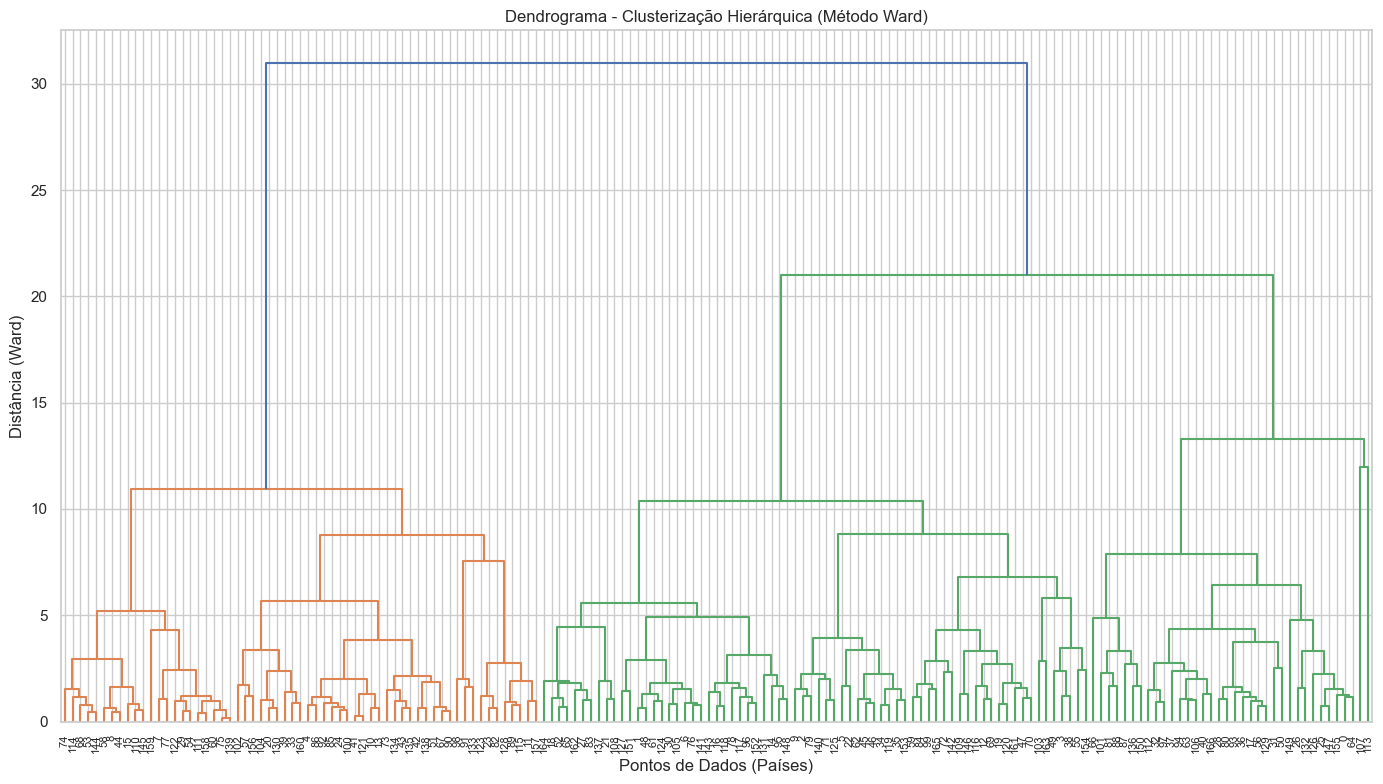

In [19]:
print("--- Iniciando Clusterização Hierárquica ---")

# 1. Visualização com Dendrograma ---

print("Gerando dendrograma...")
plt.figure(figsize=(14, 8))
plt.title("Dendrograma - Clusterização Hierárquica (Método Ward)")
plt.xlabel("Pontos de Dados (Países)")
plt.ylabel("Distância (Ward)")

# Gerar a matriz de ligação (linkage matrix)
linked = sch.linkage(X_scaled_df, method='ward')

# Plotar o dendrograma
dendrogram = sch.dendrogram(linked,
                            leaf_rotation=90.,
                            leaf_font_size=8.)


plt.tight_layout()
plt.savefig(r'evidencias/dendrograma_hierarquico.png')
print("Dendrograma salvo em 'evidencias/dendrograma_hierarquico.png'")

In [23]:
# 2. Aplicação do Modelo Hierárquico (Aglomerativo) ---

K_HIERARQUICO = 3

print(f"Aplicando Clusterização Hierárquica Aglomerativa com K={K_HIERARQUICO}...")

# Criar o modelo
hierarchical_cluster = AgglomerativeClustering(n_clusters=K_HIERARQUICO, linkage='ward')

# Treinar o modelo e prever os clusters para os dados escalados
labels_hierarquico = hierarchical_cluster.fit_predict(X_scaled_df)

# --- 3. Adicionar Labels ao DataFrame Original ---
df_analysis['Cluster_Hierarquico'] = labels_hierarquico

print("Clusterização hierárquica concluída.")
print("Nova coluna 'Cluster_Hierarquico' foi adicionada ao DataFrame 'df_analysis'.")

print("\nContagem de países por cluster hierárquico (K={K_HIERARQUICO}):")
print(df_analysis['Cluster_Hierarquico'].value_counts().sort_index())

print("\nVisualizando as primeiras linhas com o novo cluster:")
df_analysis.head()

Aplicando Clusterização Hierárquica Aglomerativa com K=3...
Clusterização hierárquica concluída.
Nova coluna 'Cluster_Hierarquico' foi adicionada ao DataFrame 'df_analysis'.

Contagem de países por cluster hierárquico (K={K_HIERARQUICO}):
Cluster_Hierarquico
0    36
1    61
2    70
Name: count, dtype: int64

Visualizando as primeiras linhas com o novo cluster:


country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  cluster  Cluster_Hierarquico  
0       9.44        56.2       5.82    553        2                    0  
1       4.49        76.3       1.65   4090        0                    2  
2      16.10        76.5       2.89   4460        0                    2  
3      22.40        60.1       6.16   3530        2                    2  
4       1.44        76.8       2.13  12200        1                    1

In [24]:
print("--- Análise dos clusters Hierárquicos (médias das features) ---")
print("Valores médios das características originais para cada cluster:")

# Agrupar pelos clusters hierárquicos e calcular a média
# Removemos 'country' (não-numérico) e 'cluster' (label do K-Means) 
# para não entrarem no cálculo da média.
cluster_means_hierarquico = df_analysis.drop(['country', 'cluster'], axis=1).groupby('Cluster_Hierarquico').mean()

# Exibir a tabela com as médias arredondadas
cluster_means_hierarquico.round(2)

--- Análise dos clusters Hierárquicos (médias das features) ---
Valores médios das características originais para cada cluster:


child_mort  exports  health  imports    income  \
Cluster_Hierarquico                                                   
0                         96.36    22.61    6.98    43.75   1805.36   
1                          7.23    53.51    8.30    51.45  34612.79   
2                         35.45    39.82    5.43    44.53   9811.29   

                     inflation  life_expec  total_fer      gdpp  
Cluster_Hierarquico                                              
0                        10.10       58.36       5.16    904.72  
1                         3.60       78.14       1.76  29496.72  
2                        10.23       70.22       2.85   4759.20

### Comparação de resultados: K-Means e Hierárquico

Os dois métodos chegaram a resultados muito semelhantes, validando que os 3 grupos de países são uma estrutura real nos dados.

#### 1. Semelhanças (Quase Idênticos nos Extremos)

Os grupos de países Desenvolvidos e Subdesenvolvidos são os mesmos em ambos os modelos, com médias quase idênticas:

- **Cluster "Desenvolvido":**
  - K-Means (Cluster 1): Renda média de 34.5k e PIB/capita de 30.1k.
  - Hierárquico (Cluster 1): Renda média de 34.6k e PIB/capita de 29.5k.
  - **Interpretação:** Os dois algoritmos concordam perfeitamente sobre quais países são desenvolvidos.

- **Cluster "Subdesenvolvido":**
  - K-Means (Cluster 2): Mortalidade infantil de 94.06 e Renda média de 2.1k.
  - Hierárquico (Cluster 0): Mortalidade infantil de 96.36 e Renda média de 1.8k.
  - **Interpretação:** Também concordam sobre quais países estão em situação mais crítica.

#### 2. Diferenças

A única diferença pequena aparece no grupo "Em Desenvolvimento":

- **Grupo "Em Desenvolvimento":**
  - K-Means (Cluster 0): Mortalidade infantil de 29.8 e Renda de 11.2k.
  - Hierárquico (Cluster 2): Mortalidade infantil de 35.4 e Renda de 9.8k.
  - **Interpretação:** Os números do K-Means são ligeiramente melhores (mortalidade menor, renda maior). Isso significa que os algoritmos discordaram sobre alguns países "de fronteira". O K-Means moveu alguns países piores para o grupo "Subdesenvolvido", enquanto o Hierárquico manteve-os no grupo "Em Desenvolvimento".

## Parte 4: Escolha de algoritmos

#### 1) Etapas do Algoritmo K-Means
1. Inicialização:

- Escolher o número de clusters desejados.
- Posicionar aleatoriamente os centroides no espaço de dados.

2. Passo de Atribuição (Associar pontos):

- Para cada ponto de dado, calcular a distância euclidiana até cada um dos K centroides.
- Atribuir cada ponto de dado ao cluster do centroide mais próximo a ele.

3. Passo de Atualização (Mover centroides):

- Após todos os pontos serem atribuídos, recalcular a posição de cada centroide.
- O novo centroide de um cluster passa a ser a média de todos os pontos de dados que foram atribuídos a ele na etapa anterior.

4. Repetição e Convergência:

- Repetir os Passos 2 e 3 (Atribuição e Atualização) continuamente.
- Interromper o algoritmo quando os centroides pararem de se mover significativamente entre uma iteração e outra, ou quando nenhum ponto de dado mudar mais de cluster.

#### 2) Algoritmo centralizando pelo baricentro (medóide)

Etapas do Algoritmo com Medóides
1. Inicialização:

- Escolher o número de clusters (K).
- Selecionar aleatoriamente K pontos de dados reais da sua base para servirem como os medóides iniciais.

2. Passo de Atribuição:

- (Idêntico ao K-Means) Para cada ponto de dado, calcular a distância até cada um dos K medóides.
- Atribuir cada ponto de dado ao cluster do medóide mais próximo.

3. Passo de Atualização (A Mudança Principal):

- Para cada um dos K clusters formados:

    3.1 Calcular o baricentro (o ponto médio, a média real) de todos os pontos que foram atribuídos a esse cluster.

    3.2 Em vez de usar esse baricentro (que pode não ser um dado real), compare com todos os pontos reais que estão dentro desse mesmo cluster.

    3.3 O ponto de dado real que tiver a menor distância para o baricentro calculado é escolhido como o novo medóide daquele cluster.

4. Repetição e Convergência:

- Repitir os Passos 2 e 3 (Atribuição e Atualização).
- Interromper o algoritmo quando os medóides não mudarem mais entre as iterações.

#### 3) O algoritmo de K-médias é sensível a outliers nos dados

O algoritmo K-Means é sensível a outliers porque seu mecanismo central de atualização, o Passo de Atualização, depende inteiramente do cálculo da média aritmética para definir a posição do centroide.

Por definição estatística, a média é uma medida de tendência central não robusta, o que significa que ela é fortemente influenciada por valores extremos (outliers).

Quando um outlier é atribuído a um cluster, ele "puxa" o centroide em sua direção. Isso desloca o centroide para longe da área mais densa do cluster, fazendo com que ele deixe de ser um bom representante.

#### 4) Por que o algoritmo de DBScan é mais robusto à presença de outliers?

O DBScan é mais robusto porque o algoritmo foi fundamentalmente projetado para identificar e separar outliers, tratando-os como rúdio, que é o "N" em DBScan. Ele não tenta forçar todos os pontos a pertencerem a um cluster, como o K-Means faz.

A lógica do DBScan funciona assim:

1. Define "Cluster" como Densidade: Um cluster só existe onde há uma "vizinhança densa" de pontos.

2. Usa Parâmetros de Densidade: Ele utiliza dois parâmetros para definir o que é "denso":

    - eps (Epsilon): A distância máxima (o raio) para procurar vizinhos.
    - min_samples: O número mínimo de pontos que devem existir dentro desse raio para que a região seja considerada "densa".

3. Identifica Outliers: Um outlier, por definição, é um ponto isolado. Esse ponto falhará em atender ao critério de densidade.

Como resultado, o DBScan simplesmente não inclui o outlier em nenhum cluster. Ele é explicitamente classificado como "ruído" e fica "sobrando", sem influenciar ou distorcer a forma ou a posição dos clusters densos que ele encontrou.